In [12]:
import zipfile
import pandas as pd

Імпорт попередньо отриманих даних

In [13]:
with zipfile.ZipFile("reviews.csv.zip", 'r') as zip_ref:
    zip_ref.extractall("reviews")

In [14]:
df = pd.read_csv('reviews/reviews.csv', sep="|")

# EDA

In [15]:
df.head()

,place_id,author_id,creation_date,mark,comment
0,1967,mh_-eMZ6K5RLWhZyISBhwA,2018-07-07,3,"If you decide to eat here, just be aware it is..."
1,12986,OyoGAe7OKpv6SyGZT5g77Q,2012-01-03,5,I've taken a lot of spin classes over the year...
2,13366,8g_iMtfSiwikVnbP2etR0A,2014-02-05,3,Family diner. Had the buffet. Eclectic assortm...
3,6416,_7bHUi9Uuf5__HHc_Q8guQ,2015-01-04,5,"Wow! Yummy, different, delicious. Our favo..."
4,6179,bcjbaE6dDog4jkNY91ncLQ,2017-01-14,4,Cute interior and owner (?) gave us tour of up...


In [16]:
df = df.drop(columns=['creation_date', 'comment'])

Перевірка структури даних та типів

In [17]:
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1499987 entries, 0 to 1499986
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   place_id   1499987 non-null  int64 
 1   author_id  1499987 non-null  object
 2   mark       1499987 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 34.3+ MB
None
place_id     0
author_id    0
mark         0
dtype: int64


Визначаємо основні статистичні характеристики

In [18]:
print(df.describe())

           place_id          mark
count  1.499987e+06  1.499987e+06
mean   1.801293e+04  3.798862e+00
std    1.194873e+04  1.405224e+00
min    1.000000e+02  1.000000e+00
25%    7.867000e+03  3.000000e+00
50%    1.642800e+04  4.000000e+00
75%    2.648800e+04  5.000000e+00
max    4.520400e+04  5.000000e+00


Перевіряємо унікальність даних

In [19]:
print(f"Кількість унікальних авторів відгуків: {df['author_id'].nunique()}")
print(f"Кількість унікальних закладів з відгуками: {df['place_id'].nunique()}")

Кількість унікальних авторів відгуків: 562720
Кількість унікальних закладів з відгуками: 41018


Визначення розподілу даних з метою оцінки якості даних

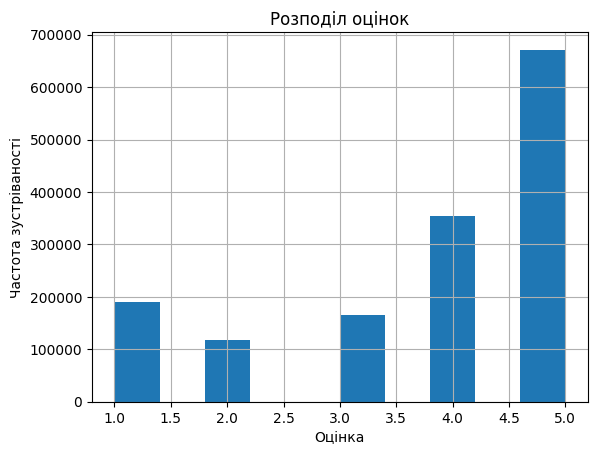

In [33]:
import matplotlib.pyplot as plt

df['mark'].hist(bins=10)
plt.xlabel('Оцінка')
plt.ylabel('Частота зустріваності')
plt.title('Розподіл оцінок')
plt.show()

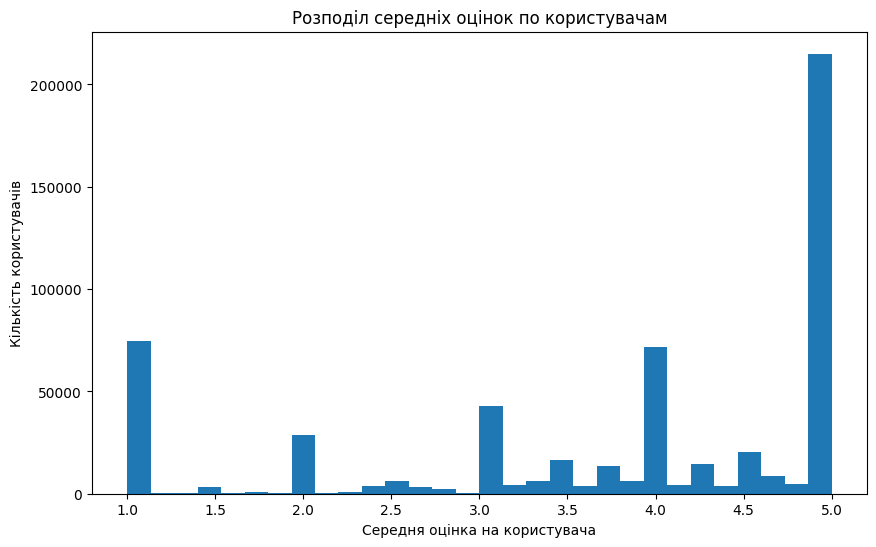

In [30]:
user_avg_ratings = df.groupby('author_id')['mark'].mean()
plt.figure(figsize=(10, 6))
plt.hist(user_avg_ratings, bins=30)
plt.xlabel('Середня оцінка на користувача')
plt.ylabel('Кількість користувачів')
plt.title('Розподіл середніх оцінок по користувачам')
plt.show()

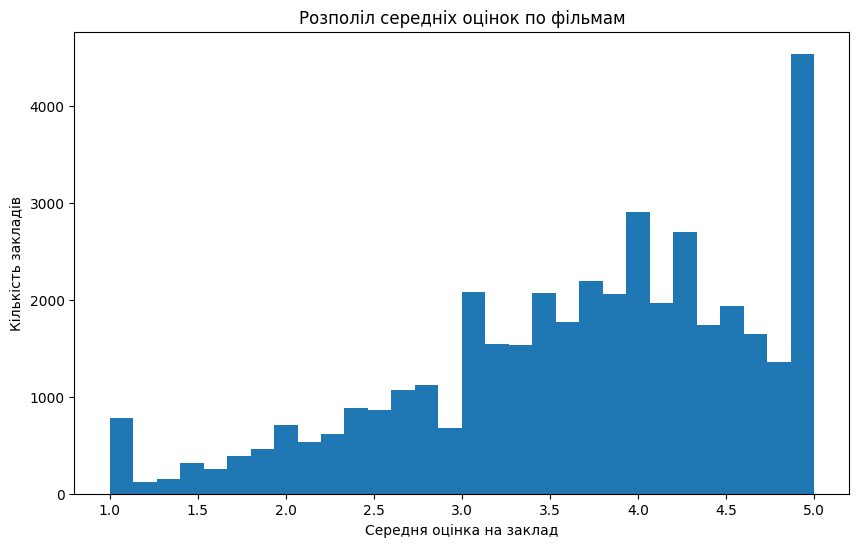

In [31]:
movie_avg_ratings = df.groupby('place_id')['mark'].mean()
plt.figure(figsize=(10, 6))
plt.hist(movie_avg_ratings, bins=30)
plt.xlabel('Середня оцінка на заклад')
plt.ylabel('Кількість закладів')
plt.title('Розполіл середніх оцінок по фільмам')
plt.show()

# Підготовка тренувального та тестового наборів даних

In [21]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357235 sha256=fc0aa6872293a22cd7744f4a05515c1a15cdee86b4872bb7fbafbc998cc11fbb
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [22]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

Створення набору даних для surprise

In [23]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['author_id', 'place_id', 'mark']], reader)

Розподіл даних на тренувальний та тестовий набори

In [24]:
trainset, testset = train_test_split(data, test_size=0.2)

# Навчання моделі

In [25]:
from surprise import SVD

Виконуємо підбір оптимальних гіперпараметрів моделі за допомогою сіткового пошуку

In [ ]:
from surprise.model_selection import GridSearchCV

param_grid = {
    'n_factors': [20, 50, 100],
    'n_epochs': [20, 30, 40],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.05, 0.1]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)

gs.fit(data)

print("Точність за метрикою RMSE для кожної комбінації гіперпараметрів:")
for params, mean_score, _ in gs.cv_results:
    print(f"Параметри: {params} - RMSE: {mean_score:.4f}")

print("\nНайкращий набір параметрів:", gs.best_params['rmse'])

best_model = gs.best_estimator['rmse']


Навчаємо найкращу модель на тренувальних даних

In [ ]:
best_model.fit(trainset)

# Оцінка якості моделі

In [23]:
from surprise import accuracy

predictions = best_model.test(testset)

rmse = accuracy.rmse(predictions)
print(f"RMSE: {rmse}")

RMSE: 1.2500
RMSE: 1.2499904779830233


# Експорт моделі для подальшого використання

In [24]:
import joblib

joblib.dump(best_model, 'matrix_factorization_model.pkl')

['matrix_factorization_model.pkl']